In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1, 100)  # 10 to 1000 K

y = 1 - x
y_2 = y**2
y_2 = 1 - 2*x + x**2
y_3 = y**3

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.plot(x, y_2)
plt.plot(x, y_3)

plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

# plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Suppress the specific DeprecationWarning
warnings.filterwarnings("ignore")
# Constants
k = 1.38e-23  # Boltzmann constant (J/K)
G = 6.67e-11  # Gravitational constant (N m^2/kg^2)
m_H = 1.67e-27  # Mass of a hydrogen atom (kg)
h = 6.63e-34 # Planck
c = 3e8 # speed of light

def B(lam,T):
    B = 2 * h * c**2/lam**5 * (np.exp(h * c/(lam * k * T)) - 1)**-1
    B = np.clip(B,1e-12,None)
    return B

lam = np.logspace(-10,0,5000)

plt.figure(figsize=(10, 6))
#for T in (0.1,0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000):
for T in (1,10,100,1000,10000,100000,1000000):    
    curve = B(lam,T)
    if T >= 1:
        Tlab = f'{T:6d}'
    else:
        Tlab = f'{T:4.1f}'
    plt.plot(lam,curve,label=Tlab)

# Plotting
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda (m)', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Black body radiation', fontsize=16)
plt.legend(title="Temperature [K]")
plt.grid(True)
plt.ylim(2e-10,None)
plt.show()

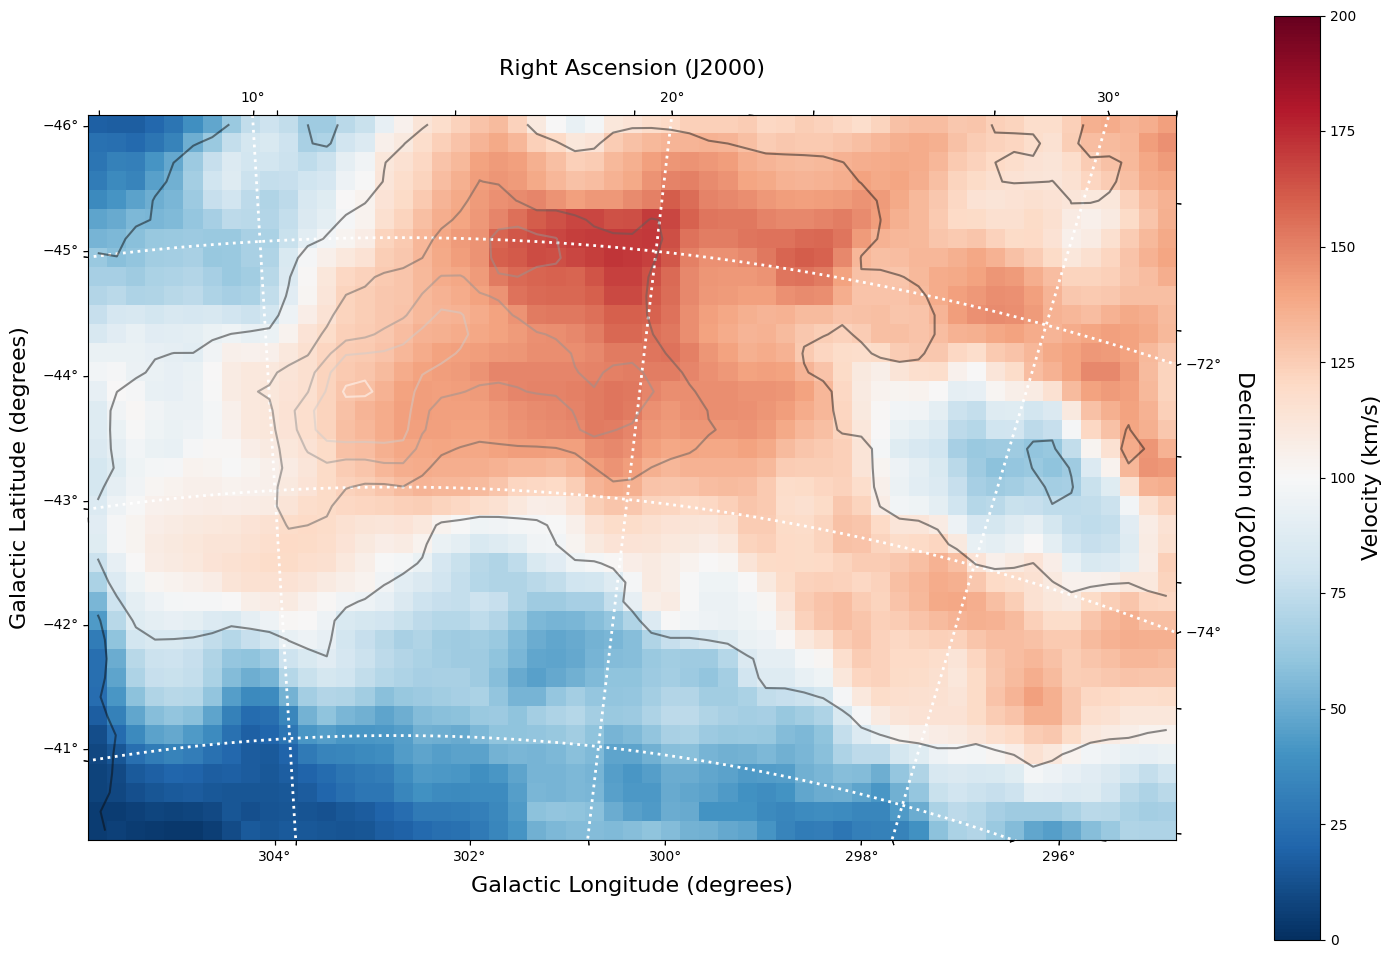

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import astropy.units as u
from astropy.utils.data import download_file
from astropy.io import fits  # We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

hi_datafile = download_file(
    'http://data.astropy.org/tutorials/FITS-cubes/reduced_TAN_C14.fits',
    cache=True, show_progress=True)

hi_data = fits.open(hi_datafile)  # Open the FITS file for reading
cube = SpectralCube.read(hi_data)  # Initiate a SpectralCube
hi_data.close()  # Close the FITS file - we already read it in and don't need it anymore!

#print(cube)

#cube[300, :, :].quicklook()  # Slice the cube along the spectral axis, and display a quick image

# cube[:, 149, 75].quicklook()  # Extract a single spectrum through the data cube

_, b, _ = cube.world[0, :, 0]  #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :]  #extract longitude world coordinates from cube

# Define desired latitude and longitude range
lat_range = [-46, -40] * u.deg 
lon_range = [306, 295] * u.deg

# Create a sub_cube cut to these coordinates
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])

sub_cube_slab = sub_cube.spectral_slab(-300. *u.km / u.s, 300. *u.km / u.s)

#print(sub_cube_slab)

# print(sub_cube)
moment_0 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=0)  # Zero-th moment 
moment_1 = sub_cube_slab.with_spectral_unit(u.km/u.s).moment(order=1)  # First moment

# Write the moments as a FITS image
# moment_0.write('hi_moment_0.fits') 
# moment_1.write('hi_moment_1.fits')

#print('Moment_0 has units of: ', moment_0.unit)
#print('Moment_1 has units of: ', moment_1.unit)

# Convert Moment_0 to a Column Density assuming optically thin media
hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

#print(moment_1.wcs)  # Examine the WCS object associated with the moment map

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# Display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200)
ax.invert_yaxis()  # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Galactic Longitude (degrees)", fontsize=16)
ax.set_ylabel("Galactic Latitude (degrees)", fontsize=16)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label('Velocity (km/s)', size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('fk5')
overlay.grid(color='white', ls='dotted', lw=2)
overlay[0].set_axislabel('Right Ascension (J2000)', fontsize=16)
overlay[1].set_axislabel('Declination (J2000)', fontsize=16)

# Overplot column density contours 
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.5, levels=levels)

In [45]:
# Query for Herschel data in a 1 degree radius around the SMC
result = ESASky.query_region_maps('SMC', radius=1*u.deg, missions='Herschel')

#print(result['HERSCHEL']['filter'])

filters = result['HERSCHEL']['filter'].astype(str)  # Convert the list of filters from the query to a string

# Construct a boolean mask, searching for only the desired filters
mask = np.array(['250, 350, 500' == s for s in filters], dtype='bool')

# Re-construct a new TableList object containing only our desired query entry
target_obs = TableList({"HERSCHEL":result['HERSCHEL'][mask]})  # This will be passed into ESASky.get_maps()

IR_images = ESASky.get_maps(target_obs)  # Download the images
#IR_images['HERSCHEL'][0]['350'].info()  # Display some information about the 350 micron image

herschel_header = IR_images['HERSCHEL'][0]['350']['image'].header
herschel_wcs = WCS(IR_images['HERSCHEL'][0]['350']['image'])  # Extract WCS information
herschel_imagehdu = IR_images['HERSCHEL'][0]['350']['image']  # Extract Image data
print(herschel_wcs)

INFO: Starting download of HERSCHEL data. (5 files) [astroquery.esasky.core]
INFO: Maps available at /Users/frim/Documents/GitHub/SuperNovae/ISM/Maps. [astroquery.esasky.core]
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : np.float64(18.99666058287459) np.float64(-71.82876374906319) 
CRPIX : np.float64(1063.0) np.float64(1517.0) 
NAXIS : 2407  2141


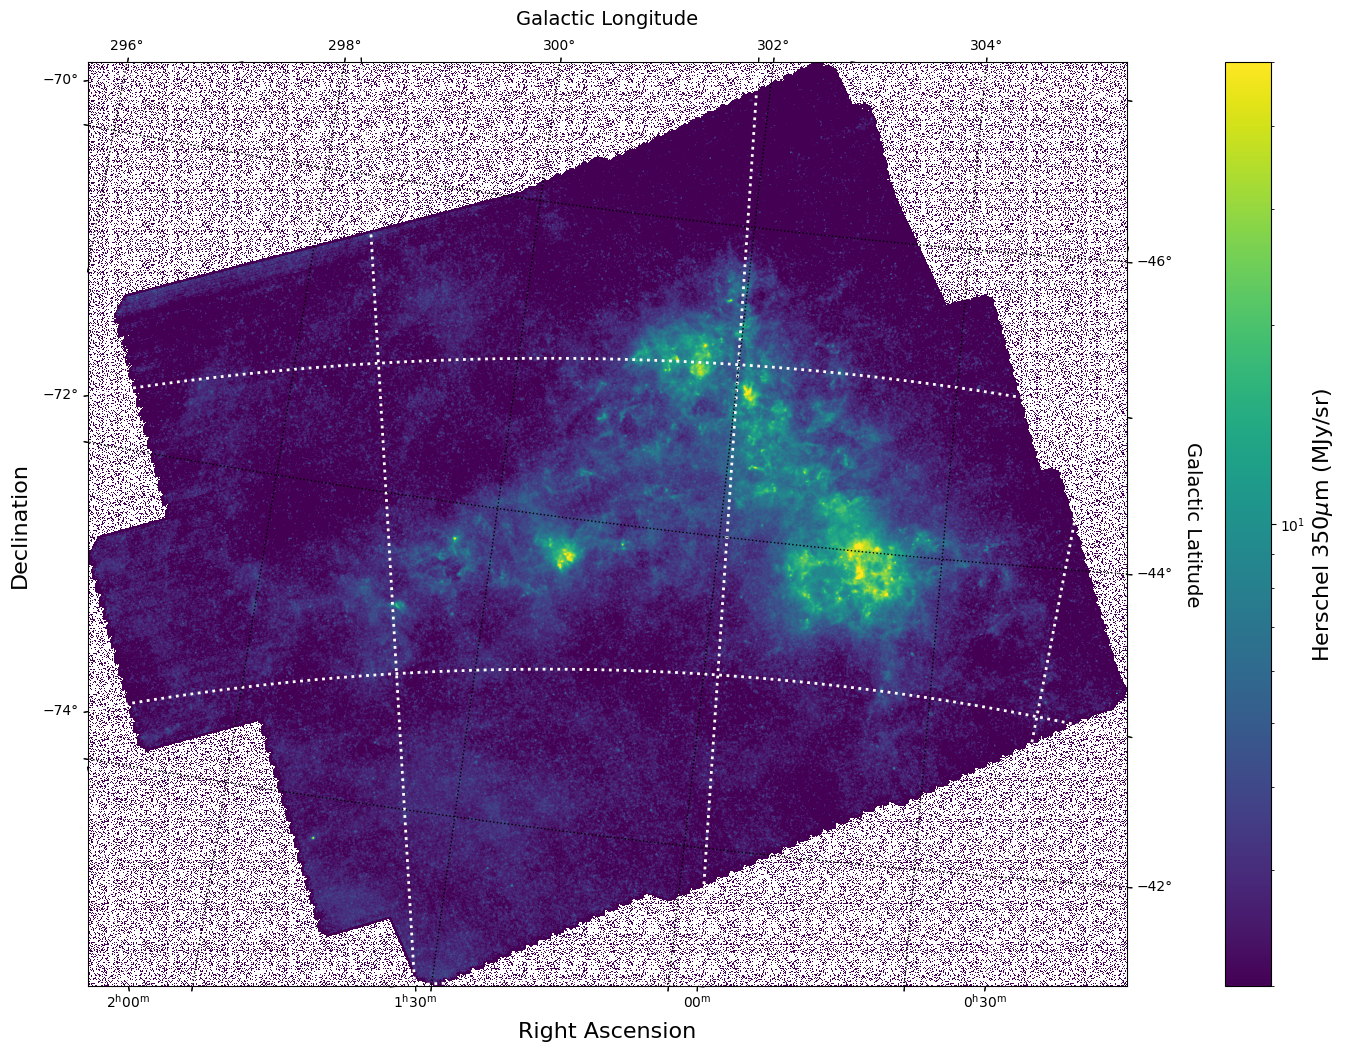

In [46]:
# Set Nans to zero
himage_nan_locs = np.isnan(herschel_imagehdu.data)
herschel_data_nonans = herschel_imagehdu.data
herschel_data_nonans[himage_nan_locs] = 0

# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=herschel_wcs)

# Display the moment map image
im = ax.imshow(herschel_data_nonans, cmap='viridis', 
               norm=LogNorm(vmin=2, vmax=50))
# ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize = 16)
ax.set_ylabel("Declination", fontsize = 16)
ax.grid(color = 'white', ls = 'dotted', lw = 2)

# Add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label(''.join(['Herschel 350'r'$\mu$m ','(', herschel_header['BUNIT'], ')']), size = 16)

# Overlay set of Galactic Coordinate Axes
overlay = ax.get_coords_overlay('galactic') 
overlay.grid(color='black', ls='dotted', lw=1)
overlay[0].set_axislabel('Galactic Longitude', fontsize=14)
overlay[1].set_axislabel('Galactic Latitude', fontsize=14)

(-0.5, 2140.5)

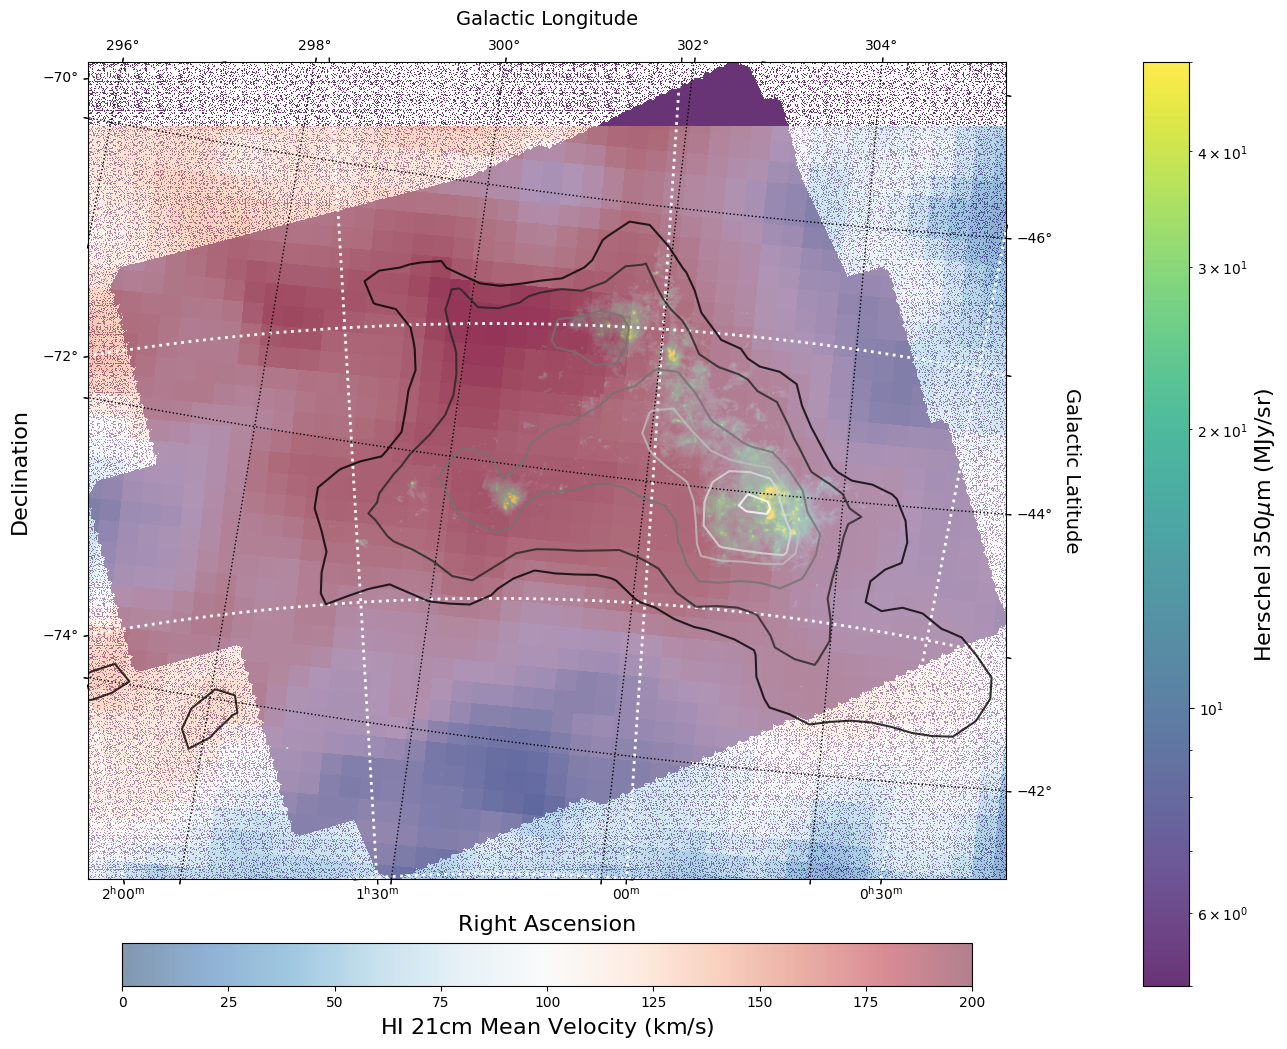

In [47]:
# Initiate a figure and axis object with WCS projection information
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection=herschel_wcs)

# Display the moment map image
im = ax.imshow(herschel_data_nonans, cmap='viridis', 
               norm=LogNorm(vmin=5, vmax=50), alpha=.8)
# ax.invert_yaxis() # Flips the Y axis 

# Add axes labels
ax.set_xlabel("Right Ascension", fontsize=16)
ax.set_ylabel("Declination", fontsize=16)
ax.grid(color = 'white', ls='dotted', lw=2)

# Extract x and y coordinate limits
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

# Add a colorbar
cbar = plt.colorbar(im, fraction=0.046, pad=-0.1)
cbar.set_label(''.join(['Herschel 350'r'$\mu$m ','(', herschel_header['BUNIT'], ')']), size=16)

# Overlay set of RA/Dec Axes
overlay = ax.get_coords_overlay('galactic')
overlay.grid(color='black', ls='dotted', lw=1)
overlay[0].set_axislabel('Galactic Longitude', fontsize=14)
overlay[1].set_axislabel('Galactic Latitude', fontsize=14)

hi_transform = ax.get_transform(hi_column_density.wcs)  # extract axes Transform information for the HI data

# Overplot column density contours 
levels = (2e21, 3e21, 5e21, 7e21, 8e21, 1e22)  # Define contour levels to use
ax.contour(hi_column_density.hdu.data, cmap='Greys_r', alpha=0.8, levels=levels,
           transform=hi_transform)  # include the transform information with the keyword "transform"

# Overplot velocity image so we can also see the Gas velocities
im_hi = ax.imshow(moment_1.hdu.data, cmap='RdBu_r', vmin=0, vmax=200, alpha=0.5, transform=hi_transform)

# Add a second colorbar for the HI Velocity information
cbar_hi = plt.colorbar(im_hi, orientation='horizontal', fraction=0.046, pad=0.07)
cbar_hi.set_label('HI 'r'$21$cm Mean Velocity (km/s)', size=16)

# Apply original image x and y coordinate limits
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)